In [22]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
import re
from PIL import Image
import glob
import seaborn as sns
import pickle, operator
from itertools import chain
from collections import Counter
from random import shuffle
from time import time
from sklearn.model_selection import train_test_split
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from wordcloud import WordCloud ,STOPWORDS
import nltk
from nltk.corpus import stopwords
# import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   
from keras.preprocessing.text import Tokenizer

In [23]:

from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.stem.lancaster import LancasterStemmer
lc = LancasterStemmer()
from nltk.stem import SnowballStemmer
sb = SnowballStemmer("english")
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
color = sns.color_palette()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
!ls /kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/ | wc -l
# ! head /kaggle/input/flickr-image-dataset/flickr30k_images/results.csv

31785


In [25]:
TEST_PERC= 0.05
VAL_PERC= 0.2
IMAGE_SIZE= 299
WORD_COUNT_THRESH= 5
EMBEDDING_FILE = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
EMBEDDING_DIM= 300
MAX_VOCAB_SIZE= 20000
DENSE_HIDDEN_UNITS = 256
LSTM_UNITS= 256
NUM_IMGS_PER_BATCH = 3
N_EPOCHS= 10
INIT_LR= 2e-3

In [5]:
base_dir = "/kaggle/input/flickr-image-dataset/flickr30k_images/"
caption_df=pd.read_csv(base_dir+"results.csv", sep= "|")
print(caption_df.columns, caption_df.shape)
caption_df.columns= [x.strip() for x in caption_df.columns] #stripping whitesapces from column names
caption_df["comment"]= caption_df["comment"].astype(str)
print(caption_df.columns)
caption_df.head()

Index(['image_name', ' comment_number', ' comment'], dtype='object') (158915, 3)
Index(['image_name', 'comment_number', 'comment'], dtype='object')


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [6]:
caption_cnt= caption_df.image_name.value_counts()
max(caption_cnt), min(caption_cnt)

(5, 5)

As we can see in the above cell that all the images have 5 captions, no more no less.


In [7]:
all_images= glob.glob(base_dir+"flickr30k_images/"+"*.jpg") #This gives the entire directory for a file
all_images_names = [x.split("/")[-1] for x in all_images] #here we are extracting just the filenames
uncommon_images= list(set(all_images_names) - set (caption_df.image_name.tolist()))
print(len(all_images), len(caption_df.image_name.unique()))
print(uncommon_images)

31783 31783
[]


As we can see in the above cell that, there are equal number of images in both CSV and JPG folder and there are no uncommon element between these two. It shows that for all the JPG images, there are 5 captions in the csv file. 

> ## Data Pre-processing

As part of data pre-processing, we do the following:

* convert to lowercase
* remove punctuations
* replace contractions with its expansions
* remove words which have numbers in them
* add __startseq__ and __endseq__ token for identifying start and end of the caption respectively.

In [8]:
contraction_map = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                       "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                       "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  
                       "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                       "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                       "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
                       "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not",
                       "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", 
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                       "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", 
                       "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
                       "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                       "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
                       "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                       "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are", "y'all've": "you all have",
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are",
                       "you've": "you have" }

In [9]:
# this function contain the code for basic text cleaning.
#since this is a text generation problem, we should not remove stopwords and do any lemmatization and stemming.
def do_cleaning(x, contraction_map):
    tokenizer=TweetTokenizer() #this is a robust tokenizer than just splitting on spaces.
    x = str(x)
    x= x.lower()
    
    #we are not removing apostraphes here because we have to expand these later using contraction_map.
    for punct in "/-":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, ' and ')
    for punct in '?!.,"#$%\()*+-/:;<=>@[\\]^_`{|}~' + '“”’\n':
        x = x.replace(punct, ' ')
    x= re.sub(r'\w*\d\w*', '', x) #remove words which have numbers in them
    x= re.sub(r' +', r' ', x) #replace more than one space with a single space
    x= x.strip(' ')
    
    words=tokenizer.tokenize(x)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[contraction_map[word] if word in contraction_map else word for word in words]
    # remove tokens with numbers in them
    #after expanding contractions, for one word there could be more than one words.  that's why is nested for is used below.
    words = [y for x in words for y in x.split(" ") if not y.isdigit()]
    clean_caption=" ".join(words)
    clean_caption= "startseq "+ clean_caption + " endseq" #add startseq and endseq in the cpations
    clean_caption= re.sub(r"'[a-zA-Z ]", r'', clean_caption) #remove apostraphe which could be before whitespace or s. e.g: mohammad's naquib' room
    return clean_caption

caption_df['comment_clean']= caption_df['comment'].apply(lambda x: do_cleaning (x, contraction_map))

In [10]:
###### run this cell for testing all the functionalities of do_cleaning function ###########
# x= "my/name: ,is, length:rope room#200 viva-voce naquib&  won't mohammad's naquib' rooom shan't we'd've alam199?!    mynaq nbhsvmjjbwd igeyu3ge675 2het ewnd ehdvdw bndehd 165naquib 887666      "
# do_cleaning(x, contraction_map)

> ## distribtution of length of captions

In [11]:
caption_df["comment_clean"]= caption_df["comment_clean"].str.strip()
caption_df["n_chars"]= caption_df["comment_clean"].apply(len)
caption_df["n_words"]= caption_df["comment_clean"].apply(lambda x:len(x.split(" ")))

In [12]:
caption_df.head()

,image_name,comment_number,comment,comment_clean,n_chars,n_words
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,startseq two young guys with shaggy hair look ...,97,18
1,1000092795.jpg,1,"Two young , White males are outside near many...",startseq two young white males are outside nea...,66,11
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,startseq two men in green shirts are standing ...,62,12
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,startseq a man in a blue shirt standing in a g...,58,12
4,1000092795.jpg,4,Two friends enjoy time spent together .,startseq two friends enjoy time spent together...,53,8


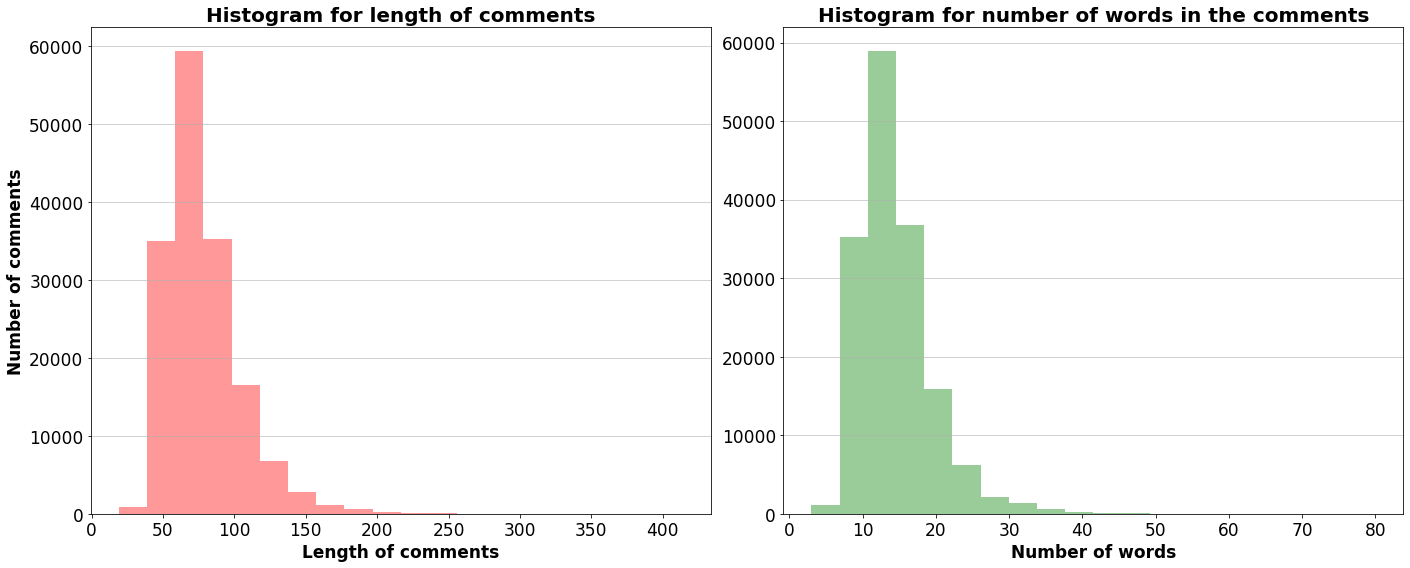

In [13]:
fig, axes = plt.subplots(1, 2, figsize= (20,8))
sns.distplot(caption_df["n_chars"], bins=20, kde= False, ax= axes[0], color= "red")
sns.distplot(caption_df["n_words"], bins=20, kde= False, ax= axes[1], color= 'green')
axes[0].set_title('Histogram for length of comments', fontsize=20, weight= 'bold')
axes[0].set_xlabel('Length of comments', fontsize=17, weight= 'bold')
axes[0].set_ylabel('Number of comments', fontsize=17, weight= 'bold')
axes[0].grid(axis='y', alpha= 0.7)
axes[0].tick_params(axis='both', which='major', labelsize=17)
axes[1].set_xlabel('Number of words', fontsize=17, weight= 'bold')
axes[1].set_ylabel('', fontsize=15)
axes[1].set_title('Histogram for number of words in the comments', fontsize=20, weight= 'bold')
axes[1].grid(axis='y', alpha= 0.7)
axes[1].tick_params(axis='both', which='major', labelsize=17)

# rects = axes[0].patches
# bins = np.arange(0, 5500, 500)
# bin_range= pd.cut(caption_df['n_chars'], bins= bins)
# labels = bin_range.value_counts().values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     axes[0].text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize= 19)

    
# rects = axes[1].patches
# bins = np.arange(0, 1400, 150)
# bin_range= pd.cut(caption_df['n_words'], bins= bins)
# labels = bin_range.value_counts().values  
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     axes[1].text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize= 19)
    
fig.tight_layout()

From above plots it can be seen that, most of the captions have length between 25 and 150, number of words between 5 and 30.

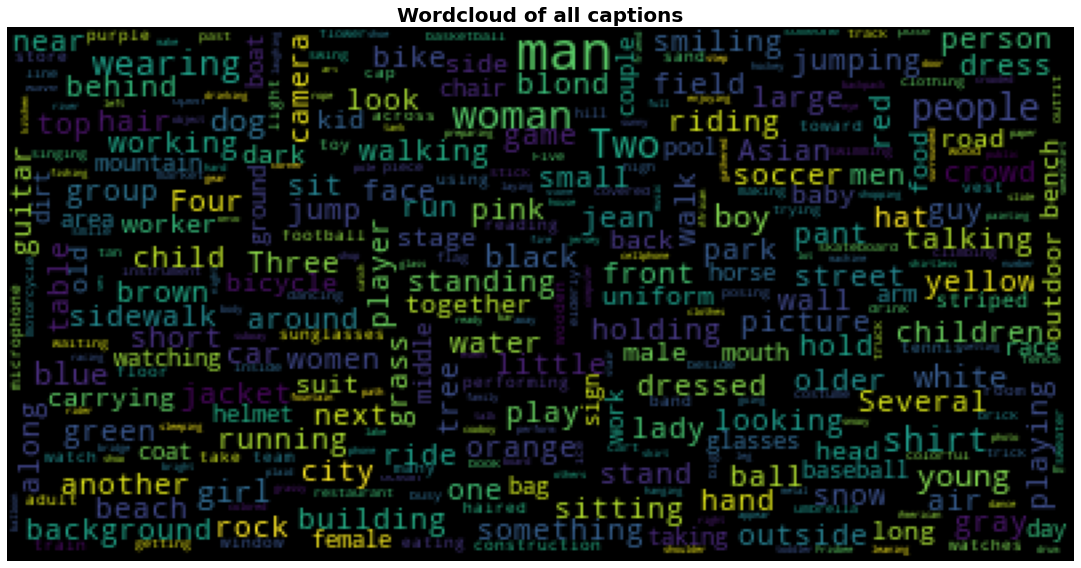

In [14]:
def make_wordcloud(text, axes, fontsize):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=2000,
                          collocations = False,
                          max_font_size=fontsize, 
                          random_state=42
                         ).generate(text)
    
    axes.imshow(wordcloud)
    plt.axis('off')

fig, axes = plt.subplots(1,1, figsize= (20,8))
make_wordcloud(caption_df['comment'].str.cat(sep= ' '), axes, fontsize= 20)
axes.set_title("Wordcloud of all captions", fontsize=20, weight= 'bold')
plt.tight_layout()
plt.show()


In [15]:
#make image to caption dictionary sort of
image_to_captions= caption_df.groupby(by='image_name').agg(captions= ('comment_clean', lambda x: x.tolist())).reset_index()
print(image_to_captions.shape, image_to_captions.columns)
image_to_captions.head()

(31783, 2) Index(['image_name', 'captions'], dtype='object')


,image_name,captions
0,1000092795.jpg,[startseq two young guys with shaggy hair look...
1,10002456.jpg,[startseq several men in hard hats are operati...
2,1000268201.jpg,[startseq a child in a pink dress is climbing ...
3,1000344755.jpg,[startseq someone in a blue shirt and hat is s...
4,1000366164.jpg,[startseq two men one in a gray shirt one in a...


In [16]:
maxlen= max(caption_df["n_words"])
vocab= np.unique(caption_df["comment_clean"].str.cat(sep= ' ').split(" "))
print("ORIGINAL TOTAL VOCABULARY SIZE: ",len(vocab))
print("MAX LEN OF A CAPTION: ", maxlen)

ORIGINAL TOTAL VOCABULARY SIZE:  18075
MAX LEN OF A CAPTION:  80


In [17]:
#split train, val, and test data
# image_to_captions = image_to_captions.sample(frac=1).reset_index(drop=True) #random shuffle the dataframe
# image_to_captions.head()
# train= image_to_captions[:24000,:]
# val= image_to_captions[24000:30000,:]
# test= image_to_captions.iloc[30000:, :]
(train_val, test) = train_test_split(image_to_captions, test_size=TEST_PERC, random_state=42)
(train, val) = train_test_split(train_val, test_size=VAL_PERC, random_state=42)
print(train.shape, val.shape, test.shape)

(24154, 2) (6039, 2) (1590, 2)


In [18]:
def read_image(image_name):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(base_dir+"flickr30k_images/"+image_name, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    # Convert PIL image to numpy array of 3-dimensions
    img = image.img_to_array(img)
    # Add one more dimension
    img = np.expand_dims(img, axis=0)
    # preprocess the images using preprocess_input() from inception module
    img = preprocess_input(img)
    return img

In [19]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet', input_shape = (IMAGE_SIZE,IMAGE_SIZE,3))
model= Model(model.input, model.layers[-2].output) #we want the output from the layer which has encoded features not from final softmax layer.

96116736/96112376 [==============================] - 1s 0us/step


In [20]:
# Function to encode a given image into a vector of size (2048, )
start = time()
def get_image_encoding(img_lst):
    all_feat_vecs= []
    for img_name in img_lst:
        img = read_image(img_name) # preprocess the image
        feat_vec = model.predict(img) # Get the encoding vector for the image
        feat_vec = np.reshape(feat_vec, feat_vec.shape[1]) # reshape from (1, 2048) to (2048, )
        all_feat_vecs.append(feat_vec)
    return all_feat_vecs

train_img_feats= np.array(get_image_encoding(train["image_name"].tolist()))
val_img_feats= np.array(get_image_encoding(val["image_name"].tolist()))
test_img_feats= np.array(get_image_encoding(test["image_name"].tolist()))
print("TIME TAKEN IN SECONDS: ", time()-start)

TIME TAKEN IN SECONDS:  1800.1113719940186


In [83]:
# Save the bottleneck train, val, and test features to disk
with open("/kaggle/working/Image_encodings/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(train_img_feats, encoded_pickle)
with open("/kaggle/working/Image_encodings/encoded_val_images.pkl", "wb") as encoded_pickle:
    pickle.dump(val_img_feats, encoded_pickle)
with open("/kaggle/working/Image_encodings/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(test_img_feats, encoded_pickle)

In [22]:
# load train, val and test image encodings from disk to memory
train_img_feats = pickle.load(open("/kaggle/working/Image_encodings/encoded_train_images.pkl", "rb"))
val_img_feats = pickle.load(open("/kaggle/working/Image_encodings/encoded_val_images.pkl", "rb"))
test_img_feats = pickle.load(open("/kaggle/working/Image_encodings/encoded_test_images.pkl", "rb"))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/Image_encodings/encoded_train_images.pkl'

In [26]:
train_captions= list(chain.from_iterable(train["captions"].tolist()))
train_captions_concat= " ".join(train_captions)
train_word_freq= dict(Counter(train_captions_concat.split(" ")))
train_word_freq_filtered= {word:freq for word, freq in train_word_freq.items() if freq >= WORD_COUNT_THRESH} #consider only those words which has count>=10 in train corpus
train_word_freq_filtered = dict(sorted(train_word_freq_filtered.items(), key=operator.itemgetter(1), reverse=True)) #sort by word frequency in descending order
vocab_train= train_word_freq_filtered.keys()
vocab_size = len(vocab_train) + 1 # one for any unknown <'unk'> word/token
vocab_size= min(vocab_size, MAX_VOCAB_SIZE) #taking minimum of actual and max vocab size
print("ORIGINAL VOCABULARY SIZE: ", len(train_word_freq))
print("VOCABULARY SIZE AFTER FILTERING: ", vocab_size)

ORIGINAL VOCABULARY SIZE:  16405
VOCABULARY SIZE AFTER FILTERING:  6767


In [35]:
#generating index to word and word to index dicts which will be used for embedding
idxtoword = {}
wordtoidx = {}

idx = 1
for word in vocab_train:
    wordtoidx[word] = idx
    idxtoword[idx] = word
    idx += 1

In [91]:
# !head ../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec

In [84]:
# Load embedding vectors
start= time()
embeddings_index = {} # empty dictionary
f = open(EMBEDDING_FILE, encoding="utf-8")

for line in f:
    values = line.strip().split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('NUMBER OF WORDS IN EMBEDDING FILE: ',len(embeddings_index))
print("TIME TAKEN IN SECONDS: ", time()-start)

NUMBER OF WORDS IN EMBEDDING FILE:  2000000


In [98]:
#make an embedding matrix
start= time()
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in wordtoidx.items():
    if i >= vocab_size: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
print('SIZE OF EMBEDDING MATRIX: ',embedding_matrix.shape)

SIZE OF EMBEDDING MATRIX:  (6767, 300)


In [2]:
caption_df

NameError: name 'caption_df' is not defined

In [ ]:
#This loads embedding with exhaustive search.
start= time()
def make_embedding_matrix(embeddings_index, wordtoidx, vocab_size): 
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM), dtype=np.float32)
    for word, i in wordtoidx.items():
        #if index is larger than vocab_size then we don't have to get the embedding of this word
        if i >= vocab_size: continue 
        #all the words in our vocab is already in lowercase
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        # if lowercase word is not found in embedding vector, search for uppercase word
        embedding_vector = embeddings_index.get(word.upper())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        # if lowercase or uppercase word is not found in embedding vector, search for capitalized word
        embedding_vector = embeddings_index.get(word.capitalize())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        # if still not found, search for stemmed word using Porter stemmer
        embedding_vector = embeddings_index.get(ps.stem(word))
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        # if still not found, search for stemmed word using Lancaster stemmer
        embedding_vector = embeddings_index.get(lc.stem(word))
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        # if still not found, search for stemmed word using Snowball stemmer
        embedding_vector = embeddings_index.get(sb.stem(word))
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        # if still not found, search for lemmatized word
        embedding_vector = embeddings_index.get(lem.lemmatize(word, "v"))
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector                 
    return embedding_matrix

embedding_matrix = make_embedding_matrix(embeddings_index, wordtoidx, vocab_size)
print("TIME TAKEN IN SECONDS: ", time()-start)
print('SIZE OF EMBEDDING MATRIX: ',embedding_matrix.shape)

In [ ]:
def create_model(embedding_matrix, img_feat_dim, maxlen):
    
    vocab_size= embedding_matrix.shape[0]
    embedding_dim= embedding_matrix.shape[1]
    
    inp_img = Input(shape=(img_feat_dim,))
    encoder_img = Dropout(0.3)(inp_img)
    encoder_img = Dense(DENSE_HIDDEN_UNITS, activation='relu')(encoder_img)
    inp_text = Input(shape=(maxlen,))
    encoder_text = Embedding(vocab_size, embed_size, weights=[embedding_matrix], mask_zero= True, trainable= False)(inp_text)
    encoder_text = SpatialDropout1D(0.3)(encoder_text)
    encoder_text = LSTM(LSTM_UNITS)(encoder_text)
    decoder = concatenate([encoder_img, encoder_text])
    decoder = Dense(DENSE_HIDDEN_UNITS, activation='relu')(decoder)
    decoder = Dropout(0.2)(decoder)
    
    output = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inp_img, inp_text], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model


In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(captions, img_feats, wordtoidx, max_length, num_imgs_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    print("here")
    # loop for ever over images
    while 1:
        print("here1")
        for i in range(captions.shape[0]) :
            n+=1
            print("here2")
            # retrieve the photo feature
            img = img_feats[i]
            captions_lst= captions.iloc[i,:]["captions"]
            for caption in captions_lst:
                # encode the sequence
                seq = [wordtoidx[word] for word in caption.split(' ') if word in wordtoidx]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(img)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_imgs_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
####### run this for testing the data_generator function ############
# for aa in data_generator(train.iloc[:7,:], train_img_feats[:7], wordtoidx, maxlen, 3):
#     print(aa[0][0].shape, aa[0][1].shape, aa[1].shape,  np.max(aa[0][0]), np.max(aa[0][1]), np.max(aa[1]), np.min(aa[1]))

In [ ]:
model.optimizer.lr = INIT_LR
file_path = "img_caption_finetuned.h5"
steps_per_epoch = train.shape[0]//NUM_IMGS_PER_BATCH
val_steps= val.shape[0]//NUM_IMGS_PER_BATCH
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_on_plateau = ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.2, patience=2, verbose=1)
callbacks_list = [checkpoint, reduce_on_plateau]
model = create_model()
train_generator= data_generator(train, train_img_feats, wordtoidx, maxlen, NUM_IMGS_PER_BATCH)
val_generator= data_generator(val, val_img_feats, wordtoidx, maxlen, NUM_IMGS_PER_BATCH)

history= model.fit_generator(train_generator, validation_data=val_generator, epochs= N_EPOCHS, steps_per_epoch=steps_per_epoch, 
                             validation_steps= val_steps, callbacks=callbacks_list, verbose=1,
                             use_multiprocessing=True, workers=4)
model.save_weights('./model_weights/model_30.h5')

In [ ]:
model.load_weights('./model_weights/model_30.h5')

In [ ]:
def predict_greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final


In [ ]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))